# Undercomplete Autoencoder

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.optim import lr_scheduler
from torchvision.utils import make_grid , save_image
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
architecture_name = "simple_net"
ngpu=1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device

device(type='cuda', index=0)

In [3]:
def create_loader(data_path,workers,batch_size):
    dataset = datasets.ImageFolder(root=data_path,
                                     transform=transforms.Compose([transforms.ToTensor()]))
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
    return loader

In [8]:
class Encoder(nn.Module):
    def __init__(self,input_dim=784,output_dim=50,ngpu=ngpu):
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden1 = nn.Linear(self.input_dim, 392)
        self.hidden2 = nn.Linear(392, 196)
        self.hidden3 = nn.Linear(196, 100)
        self.out = nn.Linear(100, self.output_dim)

    def forward(self, x):
        h = nn.Dropout(p=0.1)(torch.relu(self.hidden1(x)))
        h = nn.Dropout(p=0.1)(torch.relu(self.hidden2(h)))
        h = nn.Dropout(p=0.1)(torch.relu(self.hidden3(h)))
        return torch.sigmoid(self.out(h))

class Decoder(nn.Module):
    def __init__(self,input_dim=50,output_dim=784,ngpu=ngpu):
        super(Decoder, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden1 = nn.Linear(self.input_dim, 100)
        self.hidden2 = nn.Linear(100, 196)
        self.hidden3 = nn.Linear(196, 392)
        self.out = nn.Linear(392, self.output_dim)

    def forward(self, x):
        h = nn.Dropout(p=0.1)(torch.relu(self.hidden1(x)))
        h = nn.Dropout(p=0.1)(torch.relu(self.hidden2(h)))
        h = nn.Dropout(p=0.1)(torch.relu(self.hidden3(h)))
        x_out = torch.sigmoid(self.out(h))
        return x_out
    

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight).to(device)
        m.bias.data.fill_(0.001)
    
def define_model():
    # Instanciamos as redes
    encoder = Encoder(input_dim=784,output_dim=100).to(device)
    decoder = Decoder(input_dim=100,output_dim=784).to(device)
    if (device.type == 'cuda') and (ngpu > 1):
        encoder = nn.DataParallel(encoder, list(range(ngpu)))
        decoder = nn.DataParallel(decoder, list(range(ngpu)))

    # Inicializamos os pesos
    encoder.apply(init_weights)
    decoder.apply(init_weights)

    learning_rate, beta1, beta2 = [1e-3,0.5,0.999]
    eps,weight_decay,amsgrad = [1e-8,0,False]
    params = list(encoder.parameters()) + list(decoder.parameters())
    optimizer = optim.Adam(params,
                               lr=learning_rate,
                               betas=(beta1,beta2),
                               eps=eps,
                               weight_decay=weight_decay,
                               amsgrad=amsgrad)
    return encoder,decoder,optimizer

# Funções de perda
bce_logit_loss = nn.BCEWithLogitsLoss()
mse_loss = nn.MSELoss()

def compute_accuracy(y,y_pred):
    return accuracy_score(torch.argmax(y,dim=1).cpu().numpy(),torch.argmax(y_pred,dim=1).detach().cpu().numpy().round())

def compute_entropy(probs):
    return torch.mean(-torch.sum(probs * torch.log(probs+0.000001),dim=1))

def identity(X):
    return decoder(encoder(X))

def encode(X):
    return encoder(X)

def decode(h):
    return decoder(h)

def show_img(title,img,size = 32,img_size=28):
    print(title)
    img = img[:size].cpu().view(size,1,img_size,img_size)
    npimg = np.transpose(make_grid(img).numpy(),(1,2,0))
    plt.imshow(npimg)
    
def to_one_hot(y_tensor, ndims):
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    y_one_hot = torch.zeros(
        y_tensor.size()[0], ndims).scatter_(1, y_tensor, 1)
    return y_one_hot

In [6]:
workers      = 12
batch_size   = 32
img_size     = 28
X_dim        = 784
h_dim        = 100
train_loader = create_loader("/home/ninja/MNIST/training/",workers,batch_size)
test_loader  = create_loader("/home/ninja/MNIST/testing/" ,workers,batch_size)

In [7]:
encoder,decoder,optimizer = define_model()
lambda1 = lambda epoch: 0.95 ** epoch
scheduler = lr_scheduler.LambdaLR(optimizer,lr_lambda=[lambda1],verbose=False)

In [10]:
%%time
for epoch in range(1,11):
    loss_ = []
    for _, (X_train,y_train) in enumerate(train_loader):
        X_train = X_train[:,0,:,:].view(-1,784).to(device)
        X_encoded_train = encoder(X_train)
        X_pred_train = decoder(X_encoded_train)
        loss = mse_loss(X_pred_train,X_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()
    if epoch%2 == 0:
        for (X_test,y_test) in test_loader:
            X_test = X_test[:,0,:,:].view(-1,784).to(device)
            train_loss = loss.detach().cpu().numpy()
            X_pred_test = decoder(encoder(X_test))
            test_loss = (mse_loss(X_pred_test,X_test))
            print(f"{epoch}| Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f}")
            break

2| Train loss: 0.0249 | Test loss: 0.0270
4| Train loss: 0.0252 | Test loss: 0.0185
6| Train loss: 0.0229 | Test loss: 0.0235
8| Train loss: 0.0226 | Test loss: 0.0208
10| Train loss: 0.0213 | Test loss: 0.0223
CPU times: user 1min 14s, sys: 7.68 s, total: 1min 22s
Wall time: 1min 18s


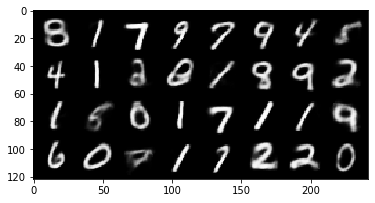

In [143]:
show_adn_save("generate",make_grid(identity(X_train[:32]).cpu().view(32,1,28,28).data))

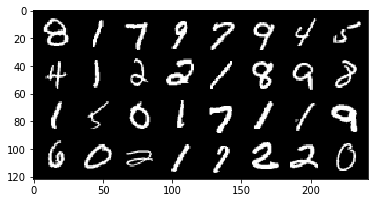

In [144]:
show_adn_save("real",make_grid(X_train[:32].cpu().view(32,1,28,28).data))

In [11]:
class Classifier(nn.Module):
    def __init__(self,input_dim,ngpu=ngpu):
        super(Classifier, self).__init__()
        self.input_dim = input_dim
        self.hidden1 = nn.Linear(self.input_dim, int(self.input_dim/2))
        self.hidden2 = nn.Linear(int(self.input_dim/2), int(self.input_dim/4))
        self.out = nn.Linear(int(self.input_dim/4), 10)

    def forward(self, x):
        h = nn.Dropout(p=0.1)(torch.relu(self.hidden1(x)))
        h = nn.Dropout(p=0.1)(torch.relu(self.hidden2(h)))
        target_out = torch.softmax(self.out(h),dim=1)
        return target_out
    
def define_clf(model_class,input_dim,output_dim):
    # Instanciamos as redes
    net = model_class(input_dim,output_dim).to(device)
    if (device.type == 'cuda') and (ngpu > 1):
        net = nn.DataParallel(net, list(range(ngpu)))

    # Inicializamos os pesos
    net.apply(init_weights)

    learning_rate, beta1, beta2 = [1e-3,0.5,0.999]
    eps,weight_decay,amsgrad = [1e-8,0,False]
    net_optimizer = optim.Adam(net.parameters(),
                               lr=learning_rate,
                               betas=(beta1,beta2),
                               eps=eps,
                               weight_decay=weight_decay,
                               amsgrad=amsgrad)
    return net,net_optimizer

In [22]:
x_clf,x_clf_optimizer = define_clf(Classifier,X_dim,10)
h_clf,h_clf_optimizer = define_clf(Classifier,h_dim,10)

In [23]:
%%time
for epoch in range(1,11):
    loss_ = []
    for _, (X_train,y_train) in enumerate(train_loader):
        X_train = X_train[:,0,:,:].view(-1,784).to(device)
        y_train = to_one_hot(y_train-1, 10).to(device)
        X_encoded_train = encoder(X_train).detach()
        y_x_clf = x_clf(X_train)
        y_h_clf = h_clf(X_encoded_train)
        x_clf_loss = bce_logit_loss(y_x_clf,y_train)
        h_clf_loss = bce_logit_loss(y_h_clf,y_train)
        x_clf_train_acc = compute_accuracy(y_train,y_x_clf)
        h_clf_train_acc = compute_accuracy(y_train,y_h_clf)
        x_clf_loss.backward()
        x_clf_optimizer.step()
        x_clf_optimizer.zero_grad()
        h_clf_loss.backward()
        h_clf_optimizer.step()
        h_clf_optimizer.zero_grad()
    scheduler.step()
    if epoch%2 == 0:
        for (X_test,y_test) in test_loader:
            X_test = X_test[:,0,:,:].view(-1,784).to(device)
            y_test = to_one_hot(y_test, 10).to(device)
            X_encoded_test = encoder(X_test).detach()
            y_x_clf_test = x_clf(X_test).detach()
            y_h_clf_test = h_clf(X_encoded_test).detach()
            x_clf_loss_test = bce_logit_loss(y_x_clf_test,y_test)
            h_clf_loss_test = bce_logit_loss(y_h_clf_test,y_test)
            x_clf_test_acc = compute_accuracy(y_test,y_x_clf_test)
            h_clf_test_acc = compute_accuracy(y_test,y_h_clf_test)
            print(f"Epoch {epoch}:")
            print(f"X Train loss: {x_clf_loss.mean():.4f} | X Test loss: {x_clf_loss_test.mean():.4f}  | X Train acc: {x_clf_train_acc.mean():.4f} | X Test acc: {x_clf_test_acc.mean():.4f}")
            print(f"h Train loss: {h_clf_loss.mean():.4f} | h Test loss: {h_clf_loss_test.mean():.4f}  | h Train acc: {h_clf_train_acc.mean():.4f} | h Test acc: {h_clf_test_acc.mean():.4f}")
            break

Epoch 2:
X Train loss: 0.6584 | X Test loss: 0.6606  | X Train acc: 0.9688 | X Test acc: 0.9375
h Train loss: 0.6765 | h Test loss: 0.6633  | h Train acc: 0.7812 | h Test acc: 0.9375
Epoch 4:
X Train loss: 0.6594 | X Test loss: 0.6616  | X Train acc: 0.9688 | X Test acc: 0.9375
h Train loss: 0.6653 | h Test loss: 0.6796  | h Train acc: 0.9062 | h Test acc: 0.7500
Epoch 6:
X Train loss: 0.6583 | X Test loss: 0.6552  | X Train acc: 0.9688 | X Test acc: 1.0000
h Train loss: 0.6647 | h Test loss: 0.6604  | h Train acc: 0.9062 | h Test acc: 0.9688
Epoch 8:
X Train loss: 0.6613 | X Test loss: 0.6607  | X Train acc: 0.9375 | X Test acc: 0.9375
h Train loss: 0.6690 | h Test loss: 0.6713  | h Train acc: 0.8750 | h Test acc: 0.8125
Epoch 10:
X Train loss: 0.6610 | X Test loss: 0.6614  | X Train acc: 0.9375 | X Test acc: 0.9375
h Train loss: 0.6675 | h Test loss: 0.6736  | h Train acc: 0.8438 | h Test acc: 0.8125
CPU times: user 1min 37s, sys: 10.3 s, total: 1min 47s
Wall time: 1min 43s
